## Firepaper_ Figure 3b - odds ratio of SOMs and high fire danger

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path
import scipy
import dask

%matplotlib inline

In [3]:
#load netcdf - calculated in Paper3_high_fire_danger_daily_counts_percentiles_90th_75th.ipynb
FFDI_extreme_90th_count = xr.open_dataset('/g/data/v45/du2523/FFDI_condition_counts/no_extreme_days_ab_90th_perc_NDJF_SEA.nc') #updated to all of Aus - forgot to change filename
#FFDI_extreme_75th_count = xr.open_dataset('/g/data/v45/du2523/FFDI_condition_counts/no_extreme_days_ab_75th_perc_NDJF_SEA.nc')

In [4]:
#Load SOM data
SOM_file = '/g/data/v45/du2523/SOM_daily_z500_anomaly_3_3.txt'
print(SOM_file)

# load txt file
SOM_date_winning_nodes = np.loadtxt(SOM_file)
SOM_winning_nodes = SOM_date_winning_nodes[0:13880,1]  #0 indexed - column 2 = column 1 #1979-2016
df_SOM_nodes = pd.DataFrame(SOM_winning_nodes,columns = ['SOM_node'])
#df_SOM_nodes

#create a date column for SOMs
SOM_date = pd.date_range(start = '01/01/1979', end = '31/12/2016', freq = 'D')
SOM_date = pd.DataFrame(SOM_date, columns = ['Date'])
#SOM_date

df_SOM = SOM_date.join(df_SOM_nodes)
#df_SOM
df_SOM.set_index('Date')
df_SOM['month'] = df_SOM['Date'].dt.month
df_SOM_NDJF = df_SOM[(df_SOM['month'] > 10) | (df_SOM['month'] < 3)]
df_SOM_NDJF

/g/data/v45/du2523/SOM_daily_z500_anomaly_3_3.txt


/jobfs/90422493.gadi-pbs/ipykernel_1728394/3042794224.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  SOM_date = pd.date_range(start = '01/01/1979', end = '31/12/2016', freq = 'D')


,Date,SOM_node,month
0,1979-01-01,3.0,1
1,1979-01-02,9.0,1
2,1979-01-03,9.0,1
3,1979-01-04,9.0,1
4,1979-01-05,9.0,1
...,...,...,...
13875,2016-12-27,4.0,12
13876,2016-12-28,4.0,12
13877,2016-12-29,4.0,12
13878,2016-12-30,2.0,12


In [4]:
#NDJF count of extreme days - saved netcdf file
# would need to match SOM3 days and fire conditions. 

#number of SOM3 days 
#number of high fire danger days

In [5]:
#Load daily FFDI data (from Andrew Dowdy BoM)
ds = xr.open_mfdataset('/g/data/v45/du2523/FFDI_daily_AndrewDowdy/FFDI/1950-2016/*.nc',
                       combine = 'nested',concat_dim='time')
ds

<xarray.Dataset>
Dimensions:  (time: 24472, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2016-12-31
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    FFDI     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes:
    FFDI:     Based_on_gridded_analysis_of_observations_(AWAP)_Jan2022_andrew...

In [6]:
#subset FFDI dataset to SOM period & NDJF 
ds = ds.sel(time = slice('1979-01-01','2016-12-31')) #dataset only goes to 2016 
ds

<xarray.Dataset>
Dimensions:  (time: 13880, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    FFDI     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes:
    FFDI:     Based_on_gridded_analysis_of_observations_(AWAP)_Jan2022_andrew...

In [7]:
#select NDJF and rechunk
ds_NDJF = ds.isel(time=ds.time.dt.month.isin([1, 2, 11,12]))
ds_NDJF = ds_NDJF.chunk({'time':-1, 'lat': 'auto', 'lon': 'auto'})
ds_NDJF

<xarray.Dataset>
Dimensions:  (time: 4570, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    FFDI     (time, lat, lon) float32 dask.array<chunksize=(4570, 75, 97), meta=np.ndarray>
Attributes:
    FFDI:     Based_on_gridded_analysis_of_observations_(AWAP)_Jan2022_andrew...

In [8]:
# Subset to East coast (all of Aus now)
#SEA = ds_NDJF.sel(lat = slice(-45,-24),lon = slice(140,154))
SEA = ds_NDJF

In [9]:
#percentiles
#Calculate percentiles and mean 
Per90 = SEA.FFDI.quantile(0.9, dim = 'time')
#Per75 = SEA.FFDI.quantile(0.75, dim = 'time')
#avg = SEA.FFDI.mean('time')

In [12]:
#subset to SOM nodes
df_SOM1 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 1.0)]
df_SOM2 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 2.0)]
df_SOM3 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 3.0)]
df_SOM4 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 4.0)]
df_SOM5 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 5.0)]
df_SOM6 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 6.0)]
df_SOM7 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 7.0)]
df_SOM8 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 8.0)]
df_SOM9 = df_SOM_NDJF[(df_SOM_NDJF['SOM_node'] == 9.0)]

In [13]:
#create time index
SOM1_time = df_SOM1['Date'].values
SOM2_time = df_SOM2['Date'].values
SOM3_time = df_SOM3['Date'].values
SOM4_time = df_SOM4['Date'].values
SOM5_time = df_SOM5['Date'].values
SOM6_time = df_SOM6['Date'].values
SOM7_time = df_SOM7['Date'].values
SOM8_time = df_SOM8['Date'].values
SOM9_time = df_SOM9['Date'].values

In [14]:
#subset xarray 
SOM1 = ds_NDJF.sel(time = SOM1_time)
SOM2 = ds_NDJF.sel(time = SOM2_time)
SOM3 = ds_NDJF.sel(time = SOM3_time)
SOM4 = ds_NDJF.sel(time = SOM4_time)
SOM5 = ds_NDJF.sel(time = SOM5_time)
SOM6 = ds_NDJF.sel(time = SOM6_time)
SOM7 = ds_NDJF.sel(time = SOM7_time)
SOM8 = ds_NDJF.sel(time = SOM8_time)
SOM9 = ds_NDJF.sel(time = SOM9_time)

In [13]:
SOM3

<xarray.Dataset>
Dimensions:  (time: 563, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-15 ... 2016-12-02
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    FFDI     (time, lat, lon) float32 dask.array<chunksize=(563, 75, 97), meta=np.ndarray>
Attributes:
    FFDI:     Based_on_gridded_analysis_of_observations_(AWAP)_Jan2022_andrew...

In [15]:
SOM1_above90 = SOM1.FFDI.where(SOM1.FFDI >Per90).count(dim='time')
SOM2_above90 = SOM2.FFDI.where(SOM2.FFDI >Per90).count(dim='time')
SOM3_above90 = SOM3.FFDI.where(SOM3.FFDI >Per90).count(dim='time')
SOM4_above90 = SOM4.FFDI.where(SOM4.FFDI >Per90).count(dim='time')
SOM5_above90 = SOM5.FFDI.where(SOM5.FFDI >Per90).count(dim='time')
SOM6_above90 = SOM6.FFDI.where(SOM6.FFDI >Per90).count(dim='time')
SOM7_above90 = SOM7.FFDI.where(SOM7.FFDI >Per90).count(dim='time')
SOM8_above90 = SOM8.FFDI.where(SOM8.FFDI >Per90).count(dim='time')
SOM9_above90 = SOM9.FFDI.where(SOM9.FFDI >Per90).count(dim='time')
#SOM3_above90.plot()

In [16]:
ndays_all = len(SOM1.time)+len(SOM2.time)+len(SOM3.time)+len(SOM4.time)+len(SOM5.time)+len(SOM6.time)+len(SOM7.time)+len(SOM8.time)+len(SOM9.time)
ndays_all

4570

In [17]:
#Odds ratio - SOM3 and high fire danger over NDJF

#n total SOM3 NDJF = 563 days
nSOM3_all = len(SOM3.time)
#n SOM3 FFDI 90th percentile = count of SOM3 days occuring on FFDI days >90th percentile
n_SOM3_high_fire = SOM3_above90 #2D array - y1
y1 = n_SOM3_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM3_all - n_SOM3_high_fire #number of non high fire danger days in SOM3 days

#not SOM3
n_all_minus_SOM3 = ndays_all - nSOM3_all
n_high_fire = SOM1_above90+SOM2_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM3 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM3 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM3/odds_other

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


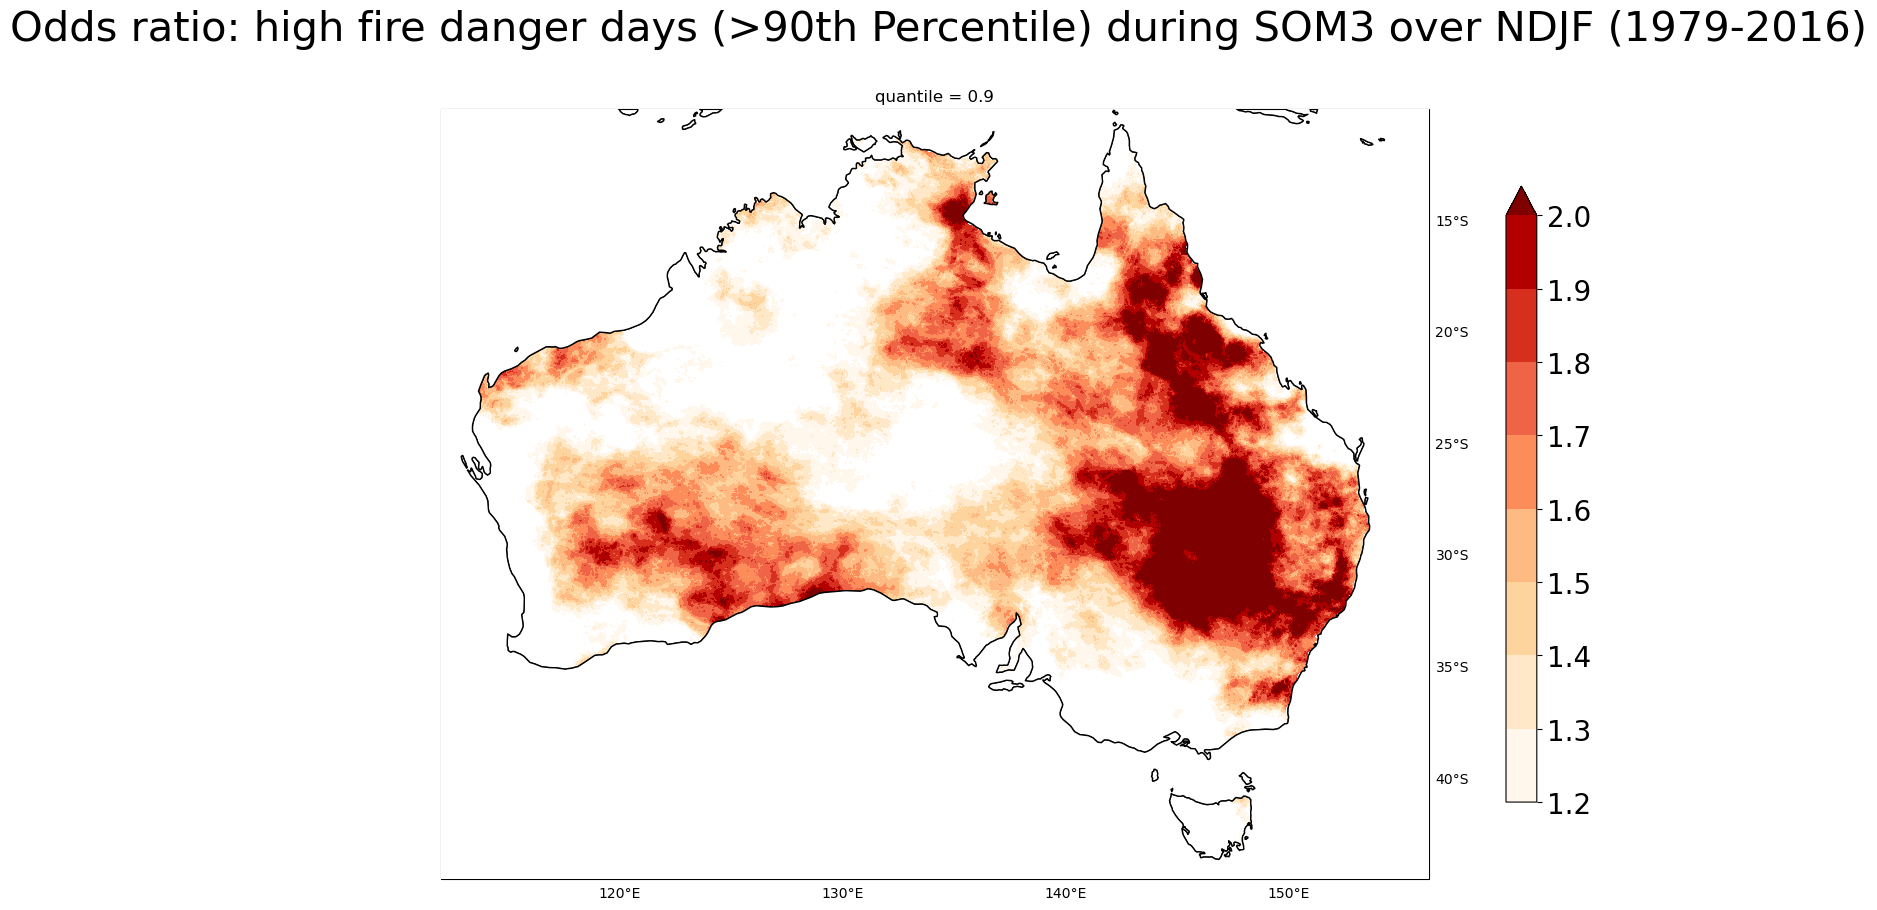

In [18]:
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value 
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM3'
period = '1979-80_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM3_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM3 over NDJF (1979-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

In [19]:
#Odds ratio - SOM7 and high fire danger over NDJF - Tassie focus


nSOM7_all = len(SOM7.time)
#n SOM3 FFDI 90th percentile = count of SOM3 days occuring on FFDI days >90th percentile
n_SOM7_high_fire = SOM7_above90 #2D array - y1
y1 = n_SOM7_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM7_all - n_SOM7_high_fire #number of non high fire danger days in SOM3 days

#not SOM7
n_all_minus_SOM7 = ndays_all - nSOM7_all
n_high_fire = SOM1_above90+SOM2_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM7 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM1 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM1/odds_other

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


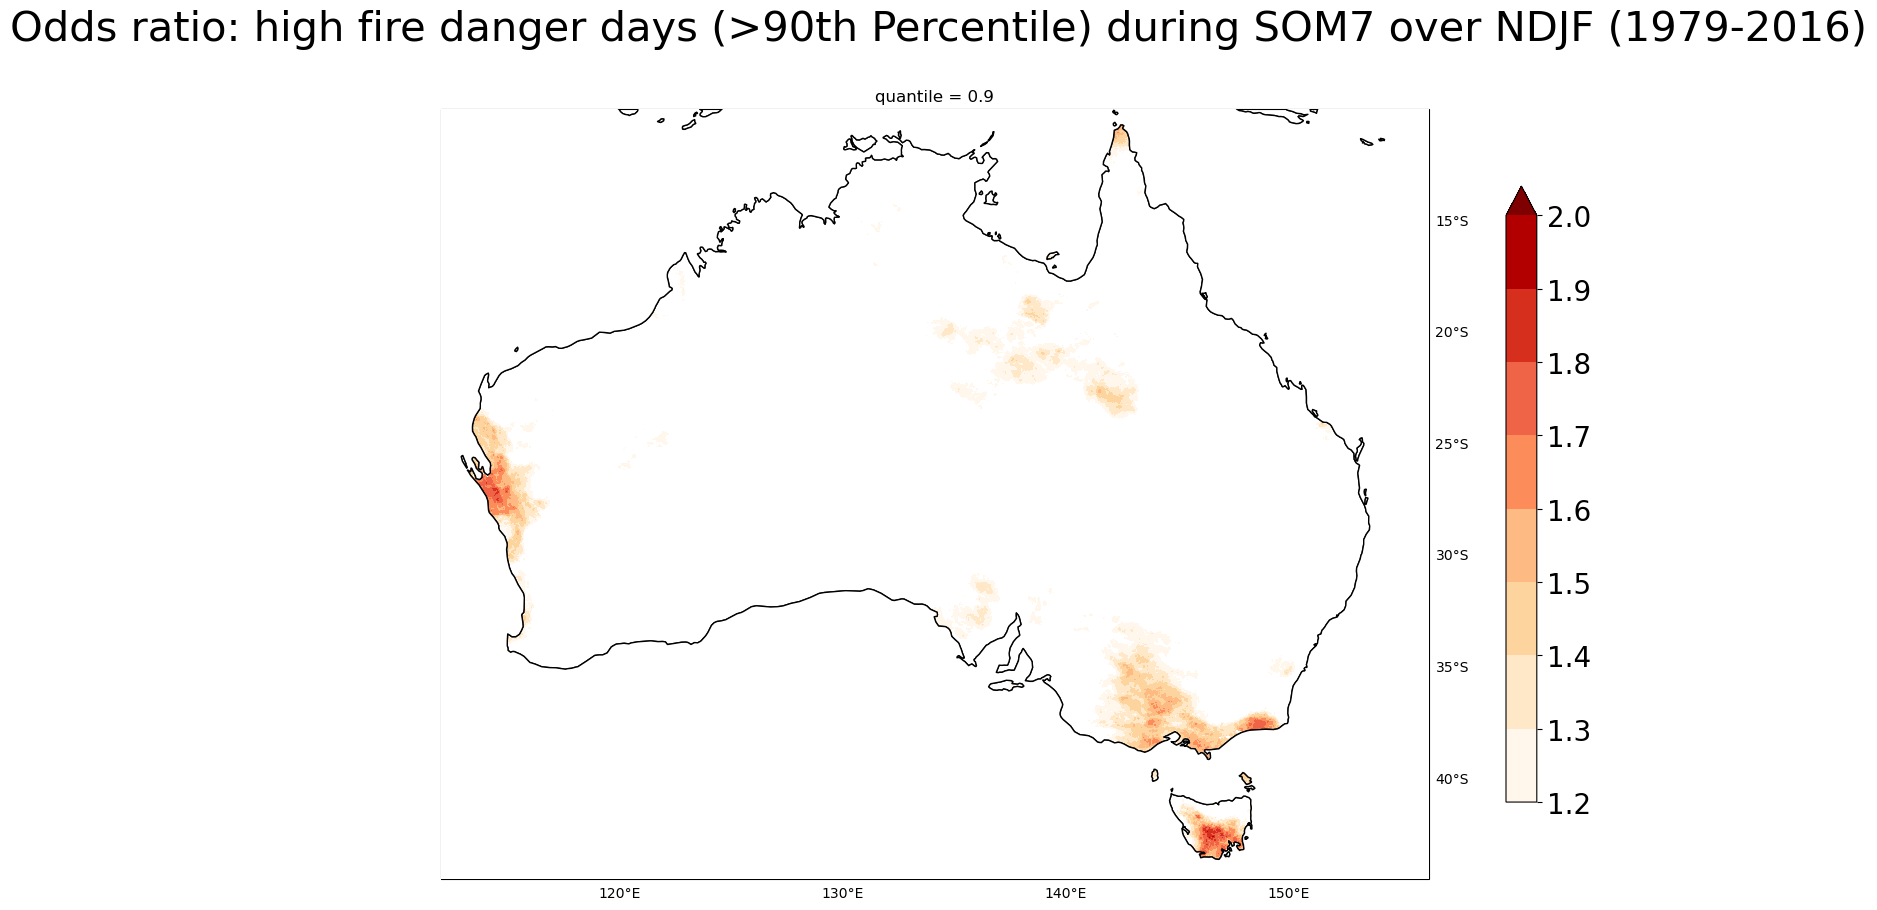

In [20]:
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value 
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM7'
period = '1979-80_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM7_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM7 over NDJF (1979-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

In [ ]:
## Remaining SOMs - include as supplementary figure with FFDI and tmax 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


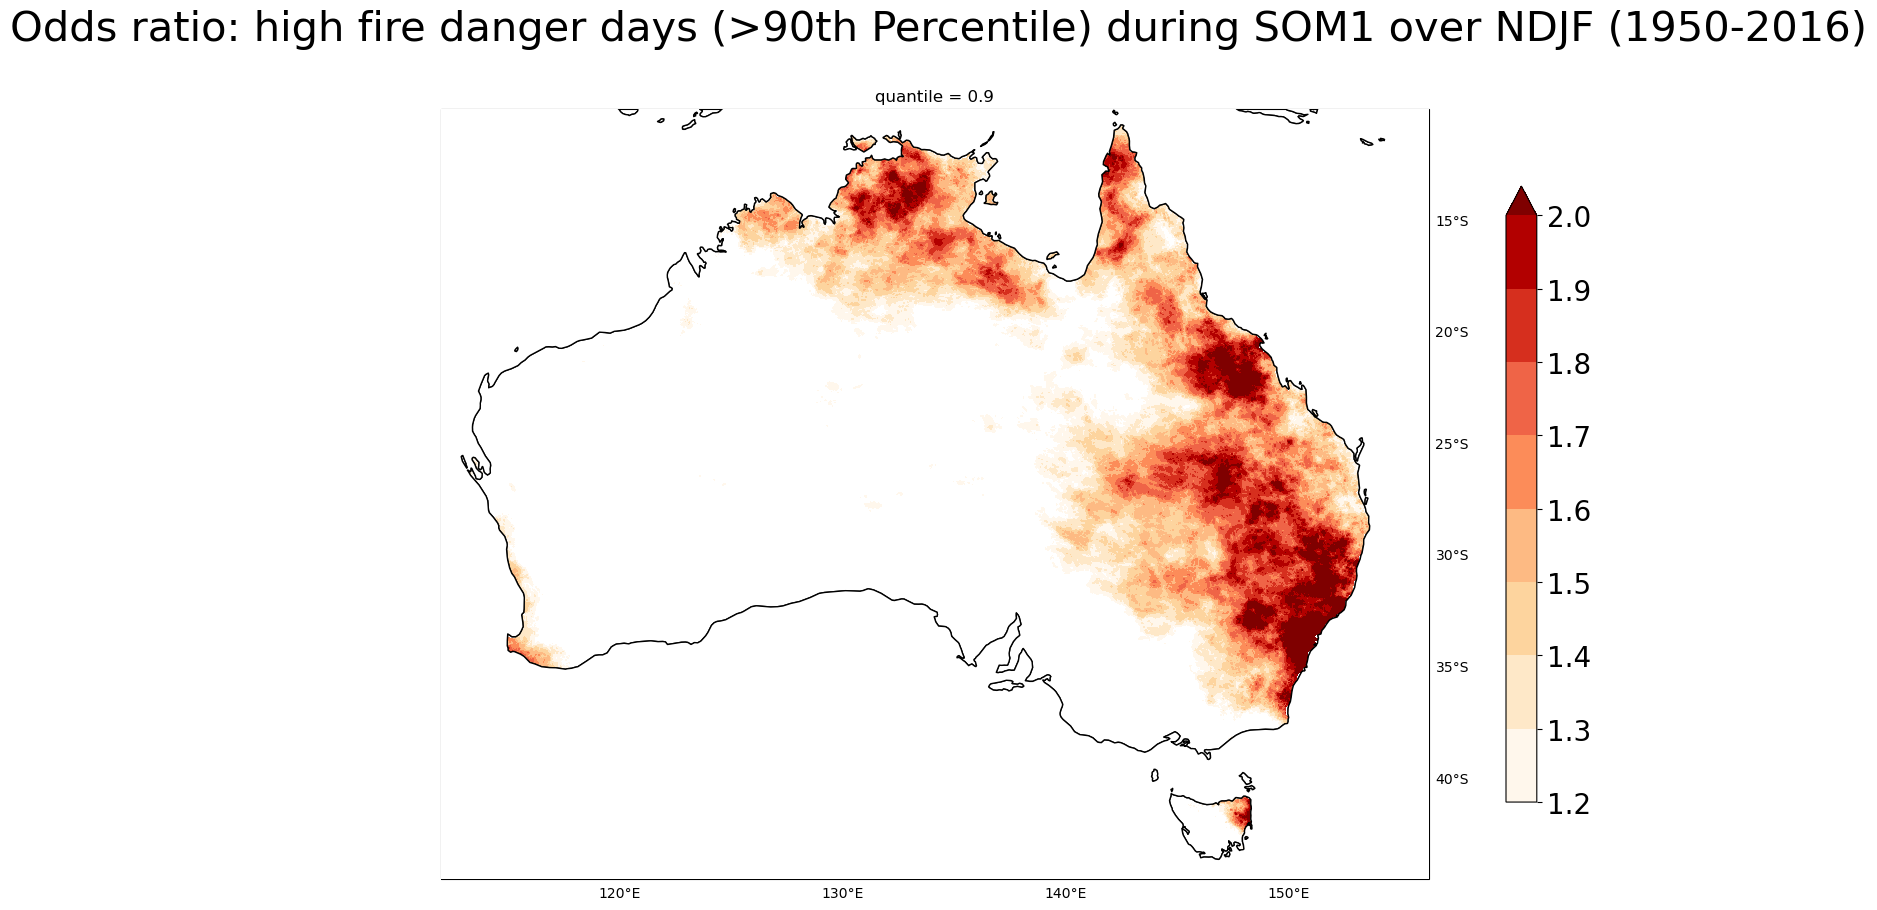

In [21]:
#Odds ratio - SOM1 and high fire danger over NDJF


nSOM1_all = len(SOM1.time)
n_SOM1_high_fire = SOM1_above90 #2D array - y1
y1 = n_SOM1_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM1_all - n_SOM1_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM1 = ndays_all - nSOM1_all
n_high_fire = SOM2_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM1 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM1 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM1/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM1'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM1_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM1 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


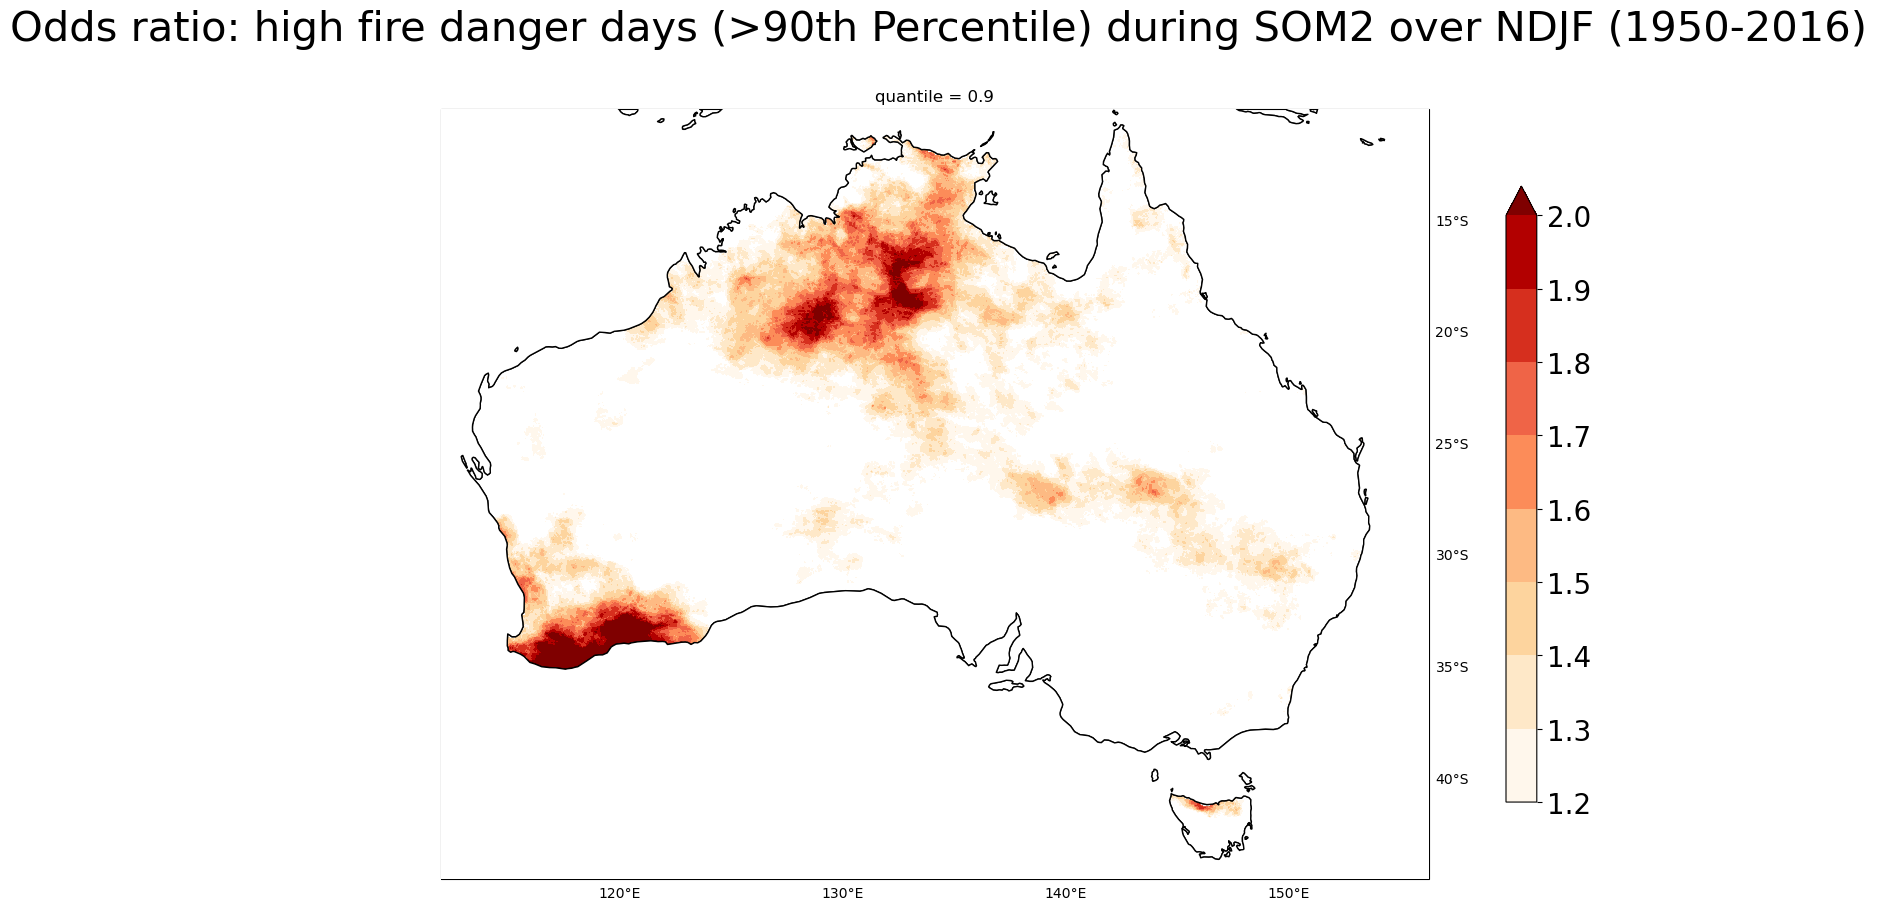

In [22]:
#Odds ratio - SOM2 and high fire danger over NDJF


nSOM2_all = len(SOM2.time)
n_SOM2_high_fire = SOM2_above90 #2D array - y1
y1 = n_SOM2_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM2_all - n_SOM2_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM2 = ndays_all - nSOM2_all
n_high_fire = SOM1_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM2 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM2 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM2/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM2'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM2_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM2 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


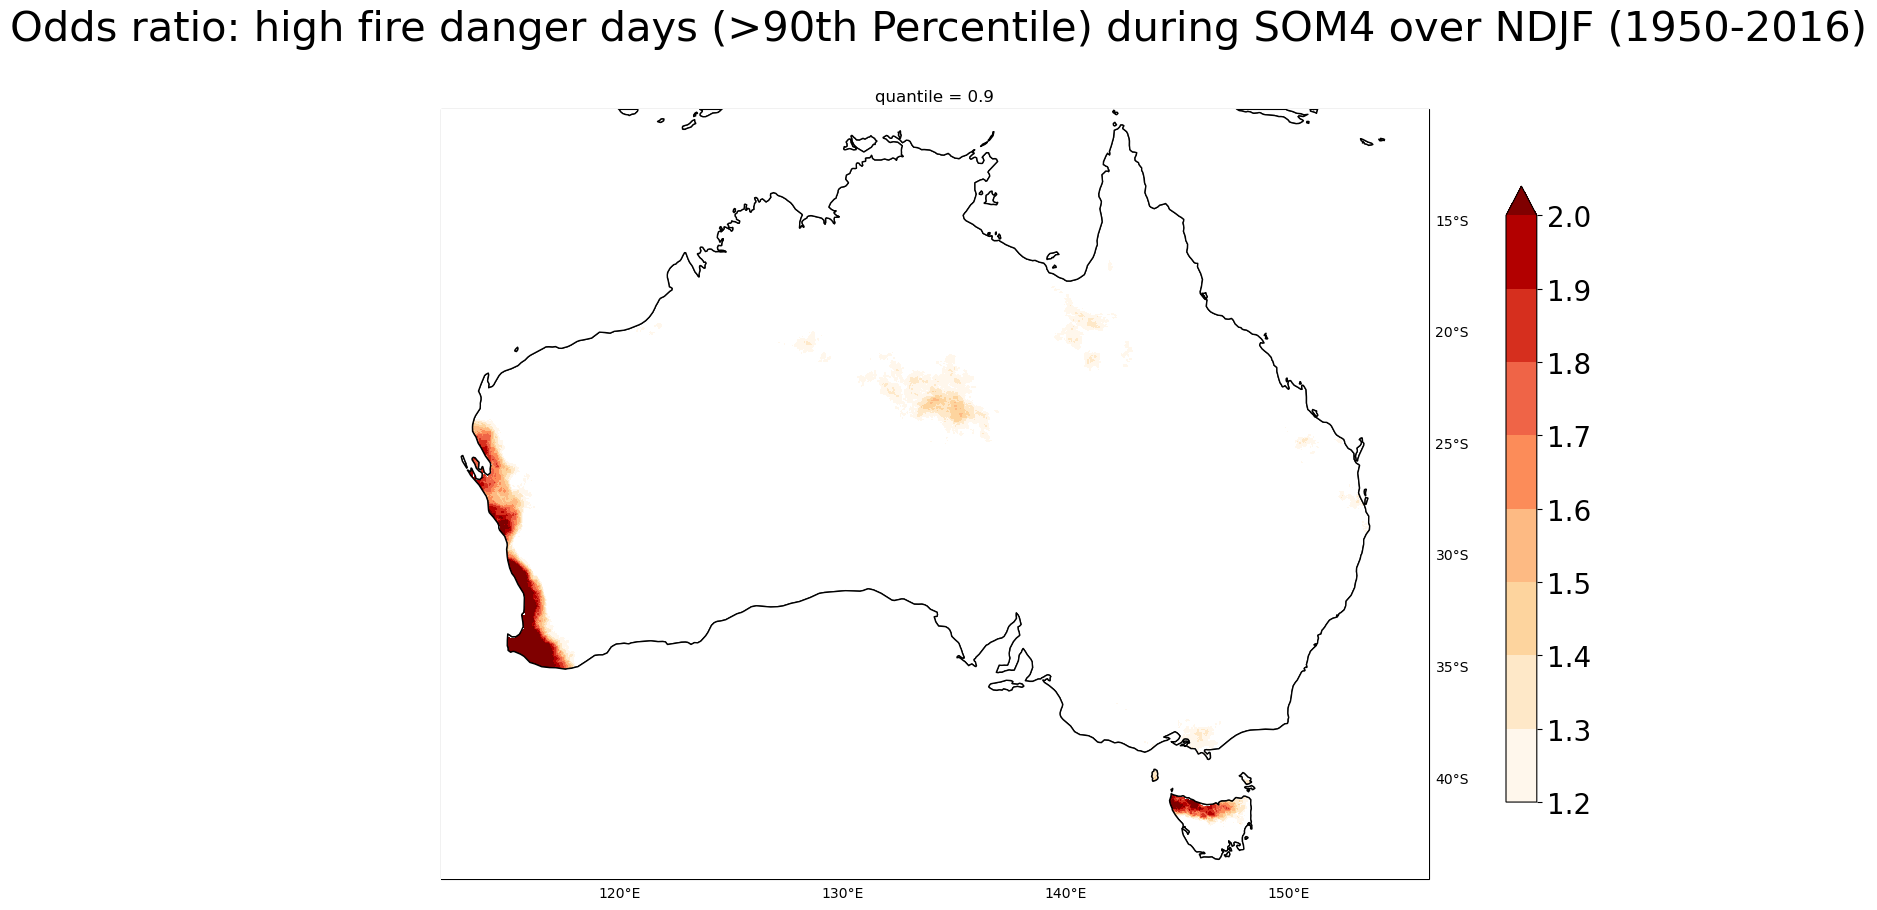

In [23]:
#Odds ratio - SOM4 and high fire danger over NDJF


nSOM4_all = len(SOM4.time)
n_SOM4_high_fire = SOM4_above90 #2D array - y1
y1 = n_SOM4_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM4_all - n_SOM4_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM4 = ndays_all - nSOM4_all
n_high_fire = SOM2_above90+SOM3_above90+SOM1_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM4 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM4 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM4/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM4'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM4_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM4 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


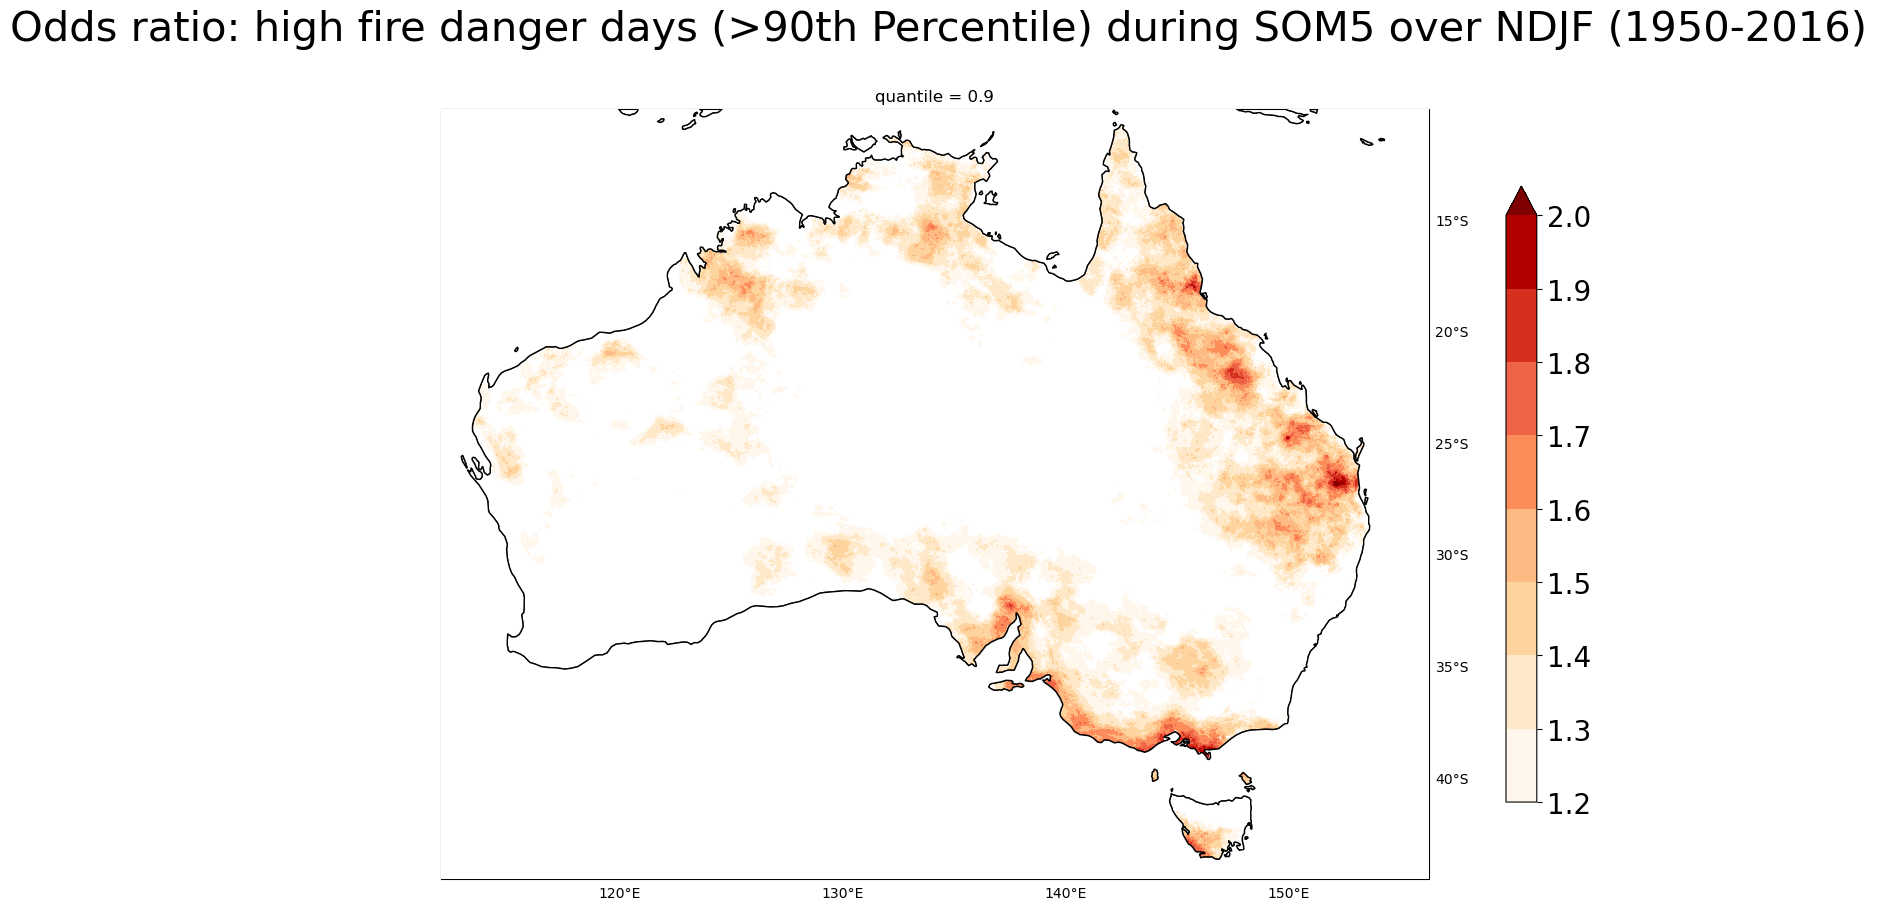

In [24]:
#Odds ratio - SOM5 and high fire danger over NDJF


nSOM5_all = len(SOM5.time)
n_SOM5_high_fire = SOM5_above90 #2D array - y1
y1 = n_SOM5_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM5_all - n_SOM5_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM5 = ndays_all - nSOM5_all
n_high_fire = SOM2_above90+SOM3_above90+SOM4_above90+SOM1_above90+SOM6_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM5 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM5 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM5/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM5'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM5_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM5 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


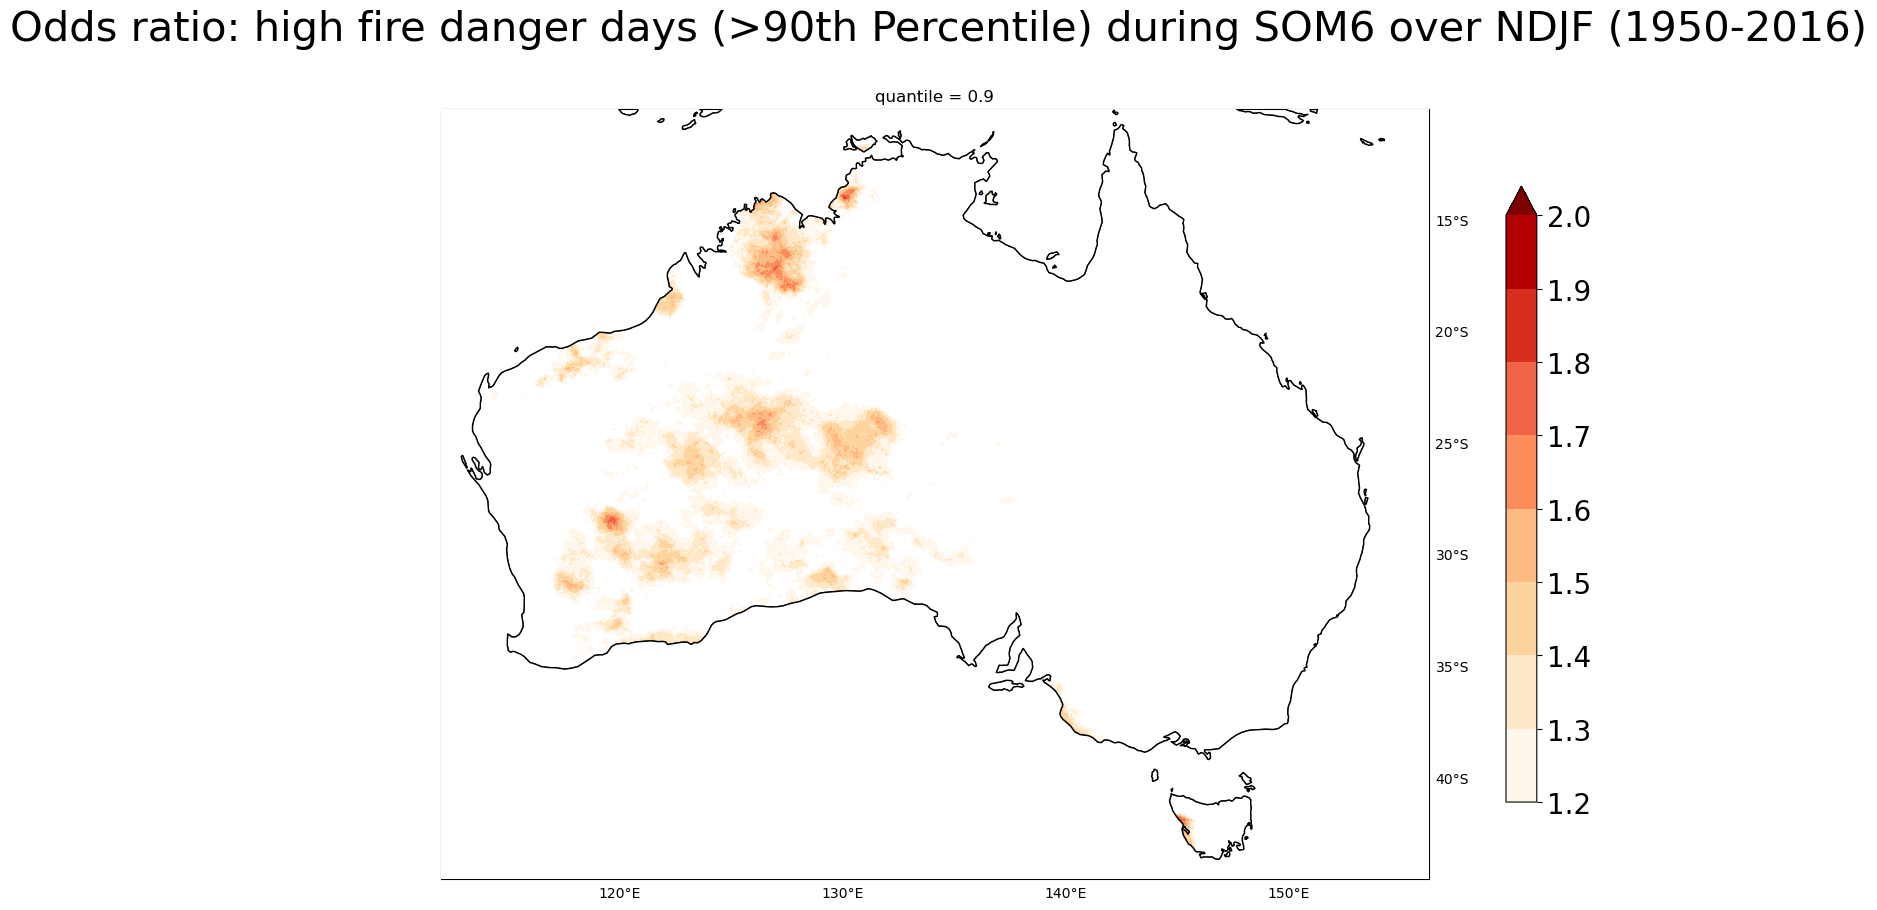

In [25]:
#Odds ratio - SOM6 and high fire danger over NDJF


nSOM6_all = len(SOM6.time)
n_SOM6_high_fire = SOM6_above90 #2D array - y1
y1 = n_SOM6_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM6_all - n_SOM6_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM6 = ndays_all - nSOM6_all
n_high_fire = SOM2_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM1_above90+SOM7_above90+SOM8_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM6 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM6 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM6/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM6'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM6_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM6 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


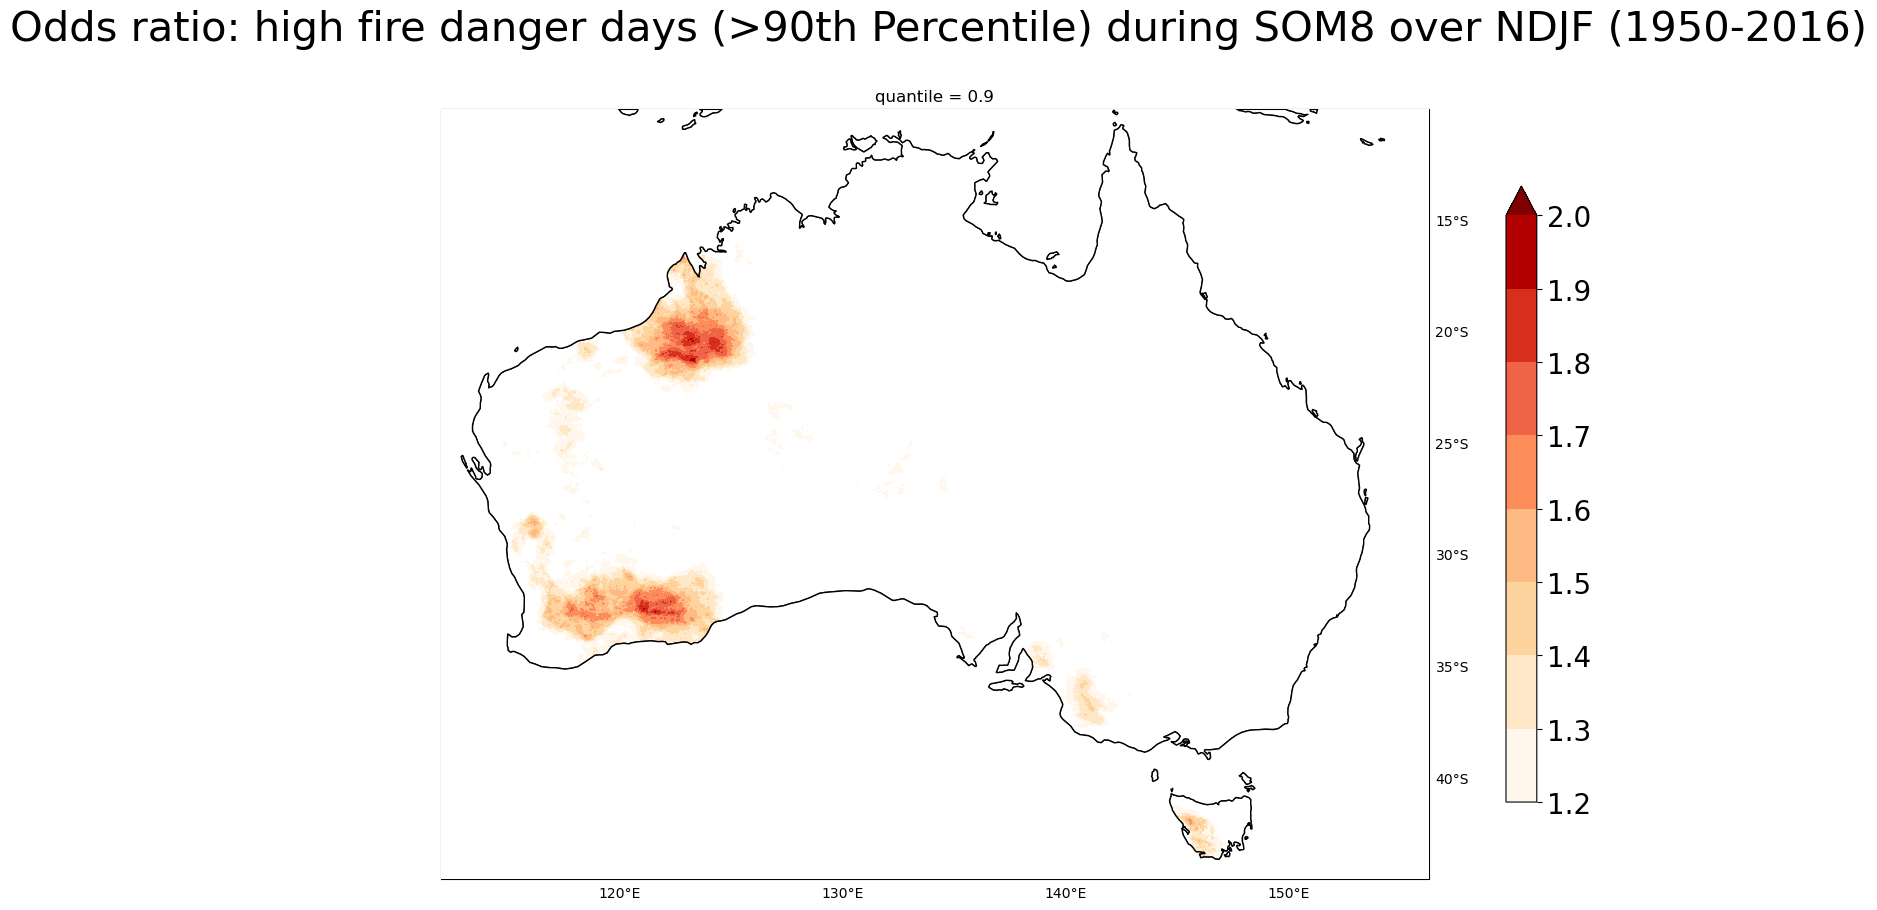

In [26]:
#Odds ratio - SOM8 and high fire danger over NDJF


nSOM8_all = len(SOM8.time)
n_SOM8_high_fire = SOM8_above90 #2D array - y1
y1 = n_SOM8_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM8_all - n_SOM8_high_fire #number of non high fire danger days in SOM3 days

#not SOM1
n_all_minus_SOM8 = ndays_all - nSOM8_all
n_high_fire = SOM2_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM1_above90+SOM9_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM6 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM8 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM8/odds_other

#Plot - takes some time
output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

#levels = np.arange(1.2,2.6,0.2) #p1/p2 value
levels = np.arange(1.2,2.1,0.1)
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM8'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM8_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM8 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


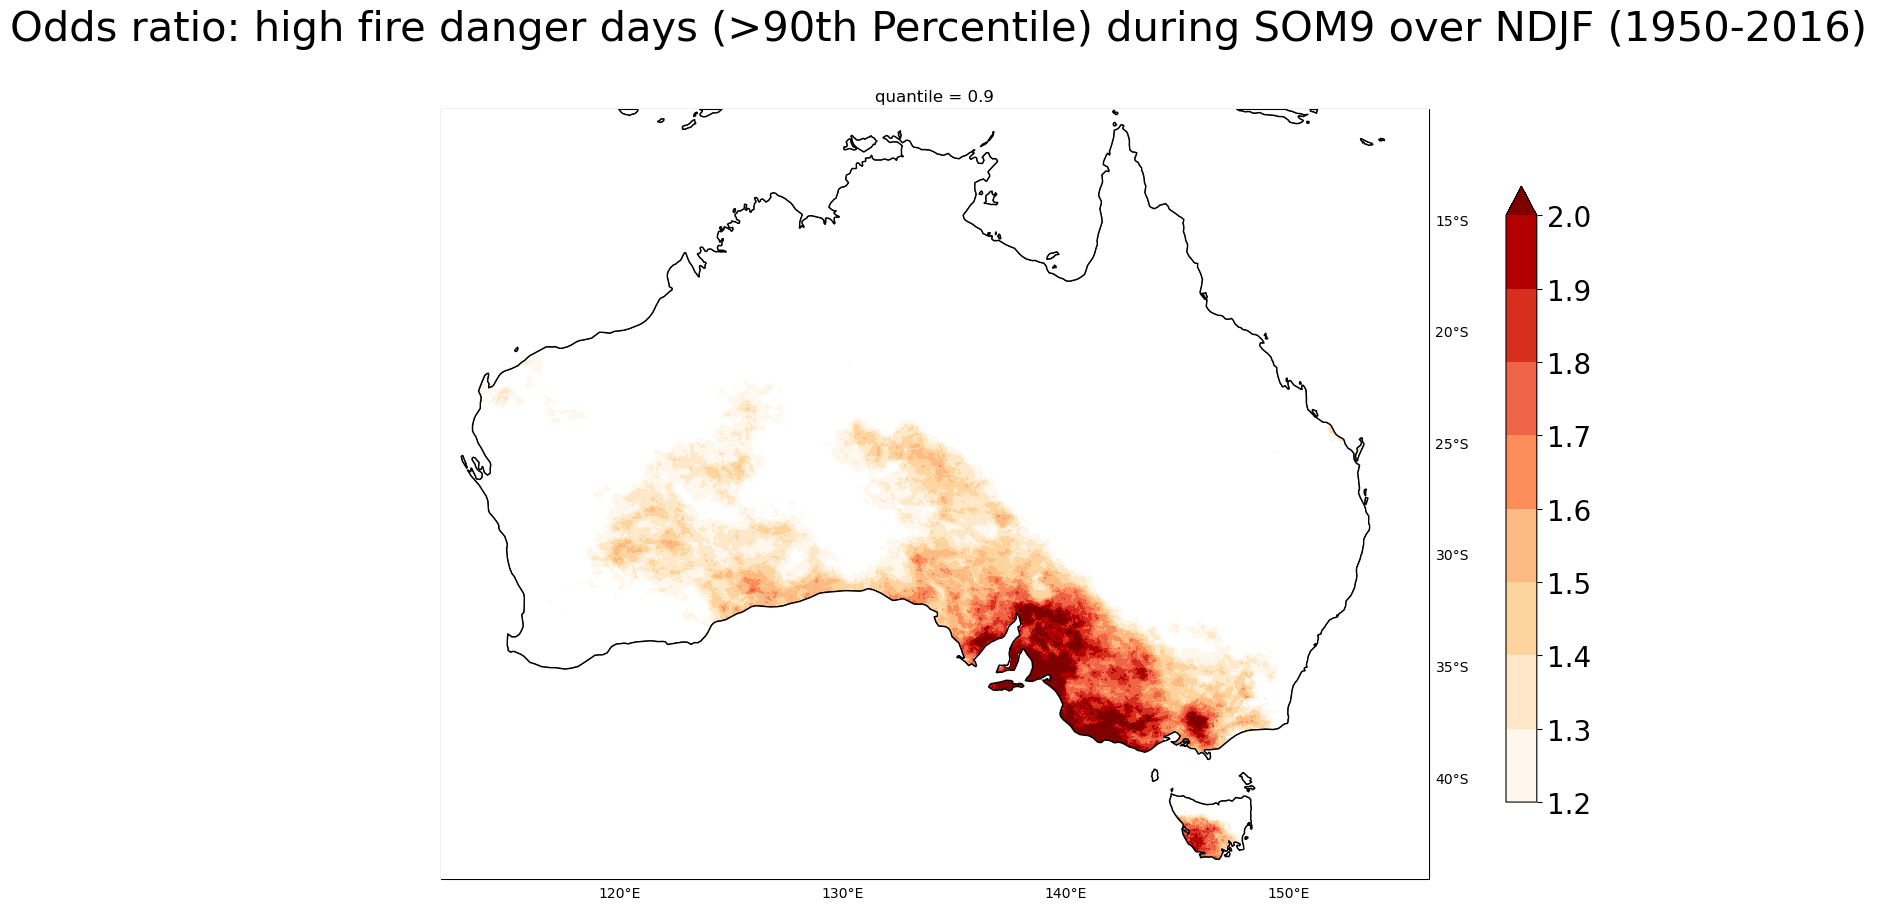

In [27]:
#Odds ratio - SOM9 and high fire danger over NDJF 


nSOM9_all = len(SOM9.time)
#n SOM3 FFDI 90th percentile = count of SOM3 days occuring on FFDI days >90th percentile
n_SOM9_high_fire = SOM9_above90 #2D array - y1
y1 = n_SOM9_high_fire #number of high fire danger days in SOM3 days
z1 = nSOM9_all - n_SOM9_high_fire #number of non high fire danger days in SOM3 days

#not SOM7
n_all_minus_SOM9 = ndays_all - nSOM9_all
n_high_fire = SOM1_above90+SOM2_above90+SOM3_above90+SOM4_above90+SOM5_above90+SOM6_above90+SOM7_above90+SOM8_above90
y2 = n_high_fire #number of high fire danger days in non SOM3 days
z2 = n_all_minus_SOM9 - n_high_fire #number of non high fire danger days in non SOM3 days

#Odds ratio
odd_SOM1 = y1/z1
odds_other = y2/z2
oddsratio90 = odd_SOM1/odds_other


output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(1.2,2.1,0.1) 
#ID = 'LDsss_FFDI_corr_sig'
var = 'SOM9'
period = '1950-51_2015-16'
ID = 'FFDI_high_fire_danger_gt_90th_perc_NDJF_odds_ratio_SOM9_occurrence'
region = 'SEA'



cp = oddsratio90.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'max',
                        cmap = 'OrRd',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
#ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='white', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Odds ratio: high fire danger days (>90th Percentile) during SOM9 over NDJF (1950-2016)',fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf')